In [209]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install ipywidgets

In [210]:

import math
import copy
import numpy
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual

plt.style.use('deeplearning.mplstyle')


In [211]:
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression. 

    ndarray: N-dimensional array: https://numpy.org/doc/stable/reference/arrays.ndarray.html

    Args: 
        x (ndarray (m,)):       data, m examples
        y (ndarray, (m,)):      target values
        w, b (scalar):          model parameters
    
    Returns 
        total_cost (float):     the cost of using w, b as the parameters for linear regression 
                                to fit the data points in x and y 
    """
    # number of the training examples
    m = x.shape[0]
    cost_sum = 0
    for i in range(m): 
        # given a training example, and parameters w, b, calculate prediction 
        # (prediction is the value of the function f_wb)
        f_wb = w * x[i] + b  # 𝑓𝑤,𝑏(𝑥(𝑖))=𝑤𝑥(𝑖)+𝑏

        # the difference b/w the prediction of the tested model (f_wb), 
        # and the actual value for the given example (y[i])
        diff = f_wb - y[i]  # 𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖)

        # loss is the cost for the given training example
        # because diff can be a negative number, it needs to be squared, 
        # and because it's squared, the loss increases rapidly when w is too small or too large
        loss = diff ** 2  # (𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖))2

        # update the cost sum with the value of loss
        cost_sum = cost_sum + loss  # ∑𝑖=0𝑚−1(𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖))2

    # calculate the total cost for the given model parameters - J(w, b)
    total_cost = 1 / (2 * m) * cost_sum  # 𝐽(𝑤,𝑏)=12𝑚∑𝑖=0𝑚−1(𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖))2
    
    return total_cost



How to automate the process of finding the optimal w and b parameters?

In [212]:
def compute_gradient(x, y, w, b):
    """
    Computes the gradient for linear regression
    
    Args: 
        x (ndarray (m,)):       data, m examples
        y (ndarray, (m,)):      target values
        w, b (scalar):          model parameters
    Returns: 
        dj_dw (scalar):         the gradient of the cost w.r.t the parameters w
        dj_db (scalar):         the gradient of the cost w.r.t. the parameters b
    """
    m = x.shape[0]
    dj_dw = 0
    dj_db = 0

    for i in range(m): 
        f_wb = w * x[i] + b

        dj_dw_i = (f_wb - y[i]) * x[i]  # (𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖))𝑥(𝑖)
        dj_db_i = f_wb - y[i]  # (𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖))

        # update both variables simultaneously
        dj_dw += dj_dw_i
        dj_db += dj_db_i 

    dj_dw = dj_dw / m  # 1/𝑚∑𝑖=0𝑚−1(𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖))𝑥(𝑖)
    dj_db = dj_db / m  # 1/𝑚∑𝑖=0𝑚−1(𝑓𝑤,𝑏(𝑥(𝑖))−𝑦(𝑖))

    return dj_dw, dj_db


In [213]:
def gradient_descent(x, y, w_initial, b_initial, alpha, number_of_iterations, cost_function, gradient_function): 
    """
    Performs gradient descent to fit w, b. 
    Updates w, b by taking number_of_iterations gradient steps with learning rate alpha

    Args: 
        x (ndarray (m,)):               data, m examples
        y (ndarray, (m,)):              target values
        w_initial, b_initial (scalar):  model parameters
        alpha (float):                  learning rate
        number_of_iterations (int):     number of iterations to run gradient descent
        cost_function:                  callback to produce cost
        gradient_function:              callback to produce gradient

    Returns: 
        w, b (scalar):                  updated values of parameters w, b after running gradient descent
        J_history (list):               history of cost values
        p_history (list):               history of parameters [w, b]
    """
    # store details of each iteration: 
    parameters_history = []
    costs_history = []
 
    w = w_initial
    b = b_initial

    for i in range(number_of_iterations): 
        dj_dw, dj_db = gradient_function(x, y, w, b)

        w = w - alpha * dj_dw  # w = 𝑤−𝛼∂𝐽(𝑤,𝑏)∂𝑤
        b = b - alpha * dj_db  # b = 𝑏−𝛼∂𝐽(𝑤,𝑏)∂𝑏

        if i < 100000:  # prevent resource exhaustion
            # save cost J at each iteration
            cost = cost_function(x, y, w, b)
            costs_history.append(cost)

            # save parameters at each iteration
            parameters_history.append([w, b])

    return w, b, costs_history, parameters_history


Because the original data stored as json has much more features than we're going to need at the moment,
we need to reduce it: 
- from the list of features of each home, leave price, area and id
- filter out those homes, that have no price or no area
- parse the values to get integers/floats

> The process of encoding JSON is usually called serialization. 
This term refers to the transformation of data into a series of bytes(hence serial) to be stored or 
transmitted across a network. 
- encoding -> writing, serializing (to file, to http)
- decoding -> reading, deserializing (to memory)

In [214]:
import json
import re

# https://stackoverflow.com/questions/47060035/python-parse-json-array
input_file = open('../../output/2023-01-16T21-04-01.949Z.json')
parsed_json = json.load(input_file)
store_list = []


def is_id(feature):
    return bool(feature["label"] == "riferimento e Data annuncio")

def is_price(feature): 
    return bool(feature["label"] == "prezzo")


def is_area(feature):
    return bool(feature["label"] == "superficie")


class RealEstate:
    id = None
    price = None
    area = None

    def set_id(self, id):
        self.id = id

    def get_id(self):
        return self.id

    def set_price(self, price):
        self.price = price

    def get_price(self): 
        return self.price
    
    def set_area(self, area): 
        self.area = area
    
    def get_area(self): 
        return self.area

# https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python
# find commas, flats, integers in a string: 
p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'

def parse_str_with_int(value): 
    if re.search(p, value) is not None:
        for catch in re.finditer(p, value):
            without_dot = str(catch[0]).replace(".", "")
            return int(without_dot)

items = []
# https://blog.teclado.com/destructuring-in-python/
for counter, item in enumerate(parsed_json):
    real_estate = RealEstate()

    for feature in item["features"]:

        if is_id(feature): 
            # id could be also parsed, to get the date out
            real_estate.set_id(feature["value"])
        
        if is_price(feature):  
            price = parse_str_with_int(feature["value"])
            real_estate.set_price(price)

        if is_area(feature):
            area = parse_str_with_int(feature["value"])
            real_estate.set_area(area)

    if real_estate.get_price() is not None and real_estate.get_area() is not None and real_estate.get_area() < 2000 and real_estate.get_price() < 400000:
        items.append(real_estate)



print("ITEMS: ")
for counter, item in enumerate(items):
    print(item.get_id())
    print(item.get_price())
    print(item.get_area())


ITEMS: 
EK-100272240 - 05/01/2023
15000
120
40080439 - 20/06/2022
22000
60
60541811 - 02/12/2022
25000
150
La Volpe e l'Uva - 18/06/2021
28000
70
321778 - 15/01/2023
33000
182
EK-55292876 - 10/01/2023
34000
100
TSS000 - 03/11/2022
35000
50
40043031 - 07/11/2022
35000
25
EK-100271526 - 05/01/2023
35000
130
EK-95288164 - 23/10/2022
35000
80
EK-89845513 - 05/05/2022
38000
122
60557692 - 06/12/2022
39000
10
EK-100271408 - 05/01/2023
39000
175
EK-88290511 - 27/05/2021
40000
114
40405961 - 02/12/2022
43000
120
EK-96247952 - 07/12/2022
45000
180
EK-77155860 - 14/04/2022
48000
150
VL ITTIRI SS 57 - 11/01/2023
50000
107
EK-97685594 - 05/08/2022
50000
50
EK-96386508 - 28/12/2022
50000
130
60659004 - 31/10/2022
55000
50
La Corte Rosa - 04/01/2023
55000
137
60579065 - 28/07/2022
59000
89
EK-98912560 - 18/10/2022
60000
108
EK-97688978 - 03/11/2022
60000
173
EK-99220190 - 04/11/2022
60000
168
60622858 - 03/11/2022
64000
80
60621836 - 04/01/2023
64000
80
18538758 - 01/09/2021
65000
121
40293092 - 28/

In [215]:
# create lists of numbers
areas = list(map(lambda x: x.get_area(), items))
prices = list(map(lambda x: x.get_price() / 1000, items))

Now that we have only the data we need in a json format, let's convert it into python array of floats: 

In [216]:
# Load our data set
x_training_examples = numpy.array(areas)   # stores features
y_training_examples = numpy.array(prices)  # stores targets


# m is the number of training examples
print(f"x_train.shape: {x_training_examples.shape}")
m = x_training_examples.shape[0]

if (m != y_training_examples.shape[0]):
    raise Exception("Number of features must be equal to number of targets")

print(f"Number of training examples is: {m}")


x_train.shape: (607,)
Number of training examples is: 607


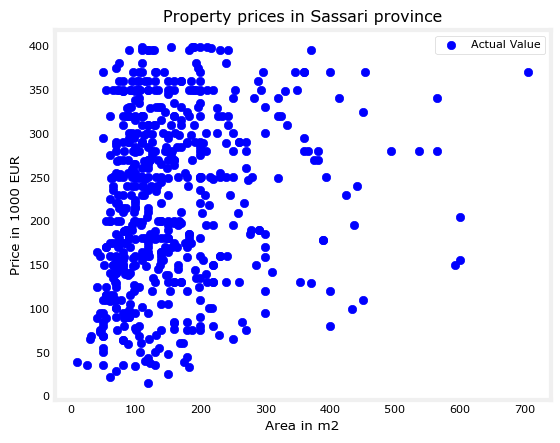

In [217]:
from plot_helpers import plot_areas_to_prices

plot_areas_to_prices(x_training_examples, y_training_examples)

In [218]:
# initialize parameters
w_init = 0
b_init = 0

# gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-5

# run gradient descent
w_final, b_final, costs_history, parameters_history = gradient_descent(x_training_examples, y_training_examples, w_init, b_init, tmp_alpha,
                                                    iterations, compute_cost, compute_gradient)
                                                    
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")


(w,b) found by gradient descent: (  1.0720,  5.4155)


w_values [-5.         -4.47368421 -3.94736842 -3.42105263 -2.89473684 -2.36842105
 -1.84210526 -1.31578947 -0.78947368 -0.26315789  0.26315789  0.78947368
  1.31578947  1.84210526  2.36842105  2.89473684  3.42105263  3.94736842
  4.47368421  5.        ]
costs [621892.6898855222, 520807.1229857798, 428840.786486671, 345993.68038819905, 272265.80469036184, 207657.15939315959, 152167.74449659244, 105797.560000661, 68546.60590536459, 40414.88221070354, 21402.388916677708, 11509.126023287106, 10735.093530531762, 19080.291438411663, 36544.719746926836, 63128.37845607722, 98831.26756586284, 143653.38707628363, 197594.73698733986, 260655.3172990313]


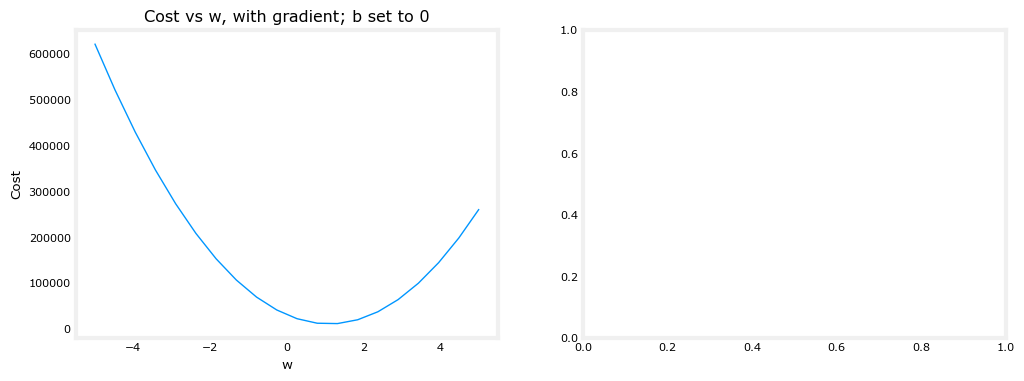

In [219]:
def plot_gradients(x_training, y_training, compute_cost, compute_gradient):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Print w vs cost to see minimum
    fix_b = 0
    w_values = numpy.linspace(-5, 5, 20)
    print(f"w_values {w_values}")

    costs = []
    for w in w_values:
        cost = compute_cost(x_training, y_training, w, fix_b)
        costs.append(cost)

    print(f"costs {costs}") 

    ax[0].plot(w_values, costs, linewidth=1)
    ax[0].set_title(f"Cost vs w, with gradient; b set to {fix_b}")
    ax[0].set_ylabel('Cost')
    ax[0].set_xlabel('w')

    # plot lines for fixed b
    # for tmp_w in [100, 200, 300]:
    #     dj_dw, dj_db = compute_gradient(x_training, y_training, tmp_w, fix_b)
    #     cost = compute_cost(x_training, y_training, tmp_w, fix_b)
        
        # add_line(dj_dw, tmp_w, j, 30, ax[0])


plot_gradients(x_training_examples, y_training_examples,
               compute_cost, compute_gradient)

# plt.show()


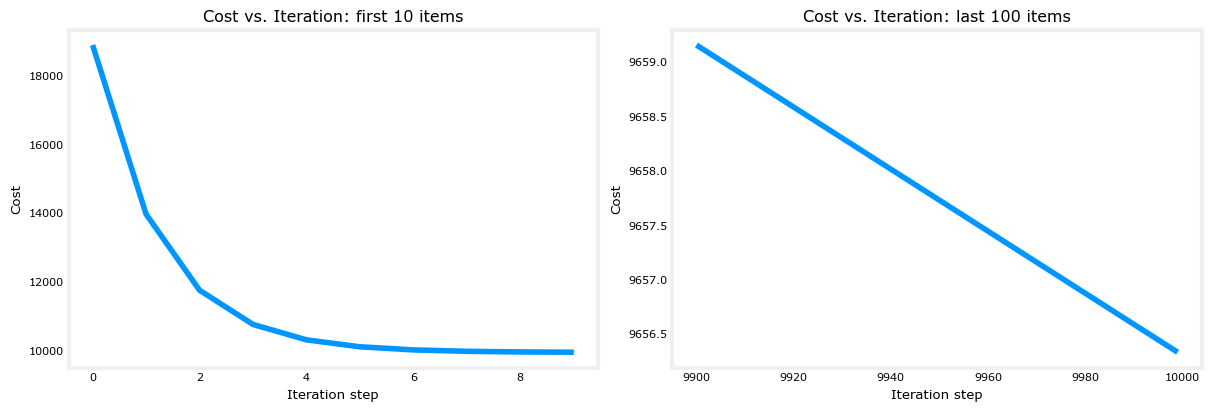

In [222]:
# plot cost versus iteration

def plot_cost_on_iteration(first_n_items, last_m_items): 
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
    label_x = 'Iteration step'
    label_y = 'Cost'

    n = first_n_items
    first_items = costs_history[:n]
    ax1.plot(first_items)
    ax1.set_title(f"Cost vs. Iteration: first {len(first_items)} items")
    ax1.set_xlabel(label_x)
    ax1.set_ylabel(label_y)

    m = last_m_items
    last_items = costs_history[-m:]
    ax2.plot((iterations - m) + numpy.arange(len(last_items)), last_items)
    ax2.set_title(f"Cost vs. Iteration: last {len(last_items)} items")
    ax2.set_xlabel(label_x)
    ax2.set_ylabel(label_y)

    plt.show()


plot_cost_on_iteration(10, 100)